In [1]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from datetime import datetime, timedelta
from src.indicators.sma import calculate_sma
from pymongo import MongoClient
import json

In [2]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [3]:
db = client["forex_data"]
collections = db.list_collection_names()

In [4]:
# Choose a collection (for example EUR_USD_H1)
collection_name = "EUR_USD_H1"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_H1 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_H1.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_H1["open"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_H1["high"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_H1["low"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_H1["close"] = df_EURUSD_H1["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_H1 = df_EURUSD_H1[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_H1)}")
print("\nFirst few rows:")
print(df_EURUSD_H1.head())


DataFrame info for EUR_USD_H1:
Total number of candles: 62153

First few rows:
                     volume     open     high      low    close
time                                                           
2025-02-11 03:00:00    2889  1.02932  1.03006  1.02922  1.02983
2025-02-11 04:00:00    3066  1.02982  1.03044  1.02976  1.03043
2025-02-11 05:00:00    2909  1.03044  1.03060  1.03022  1.03047
2025-02-11 06:00:00    4099  1.03047  1.03106  1.03042  1.03052
2025-02-11 07:00:00    5672  1.03052  1.03080  1.03010  1.03033


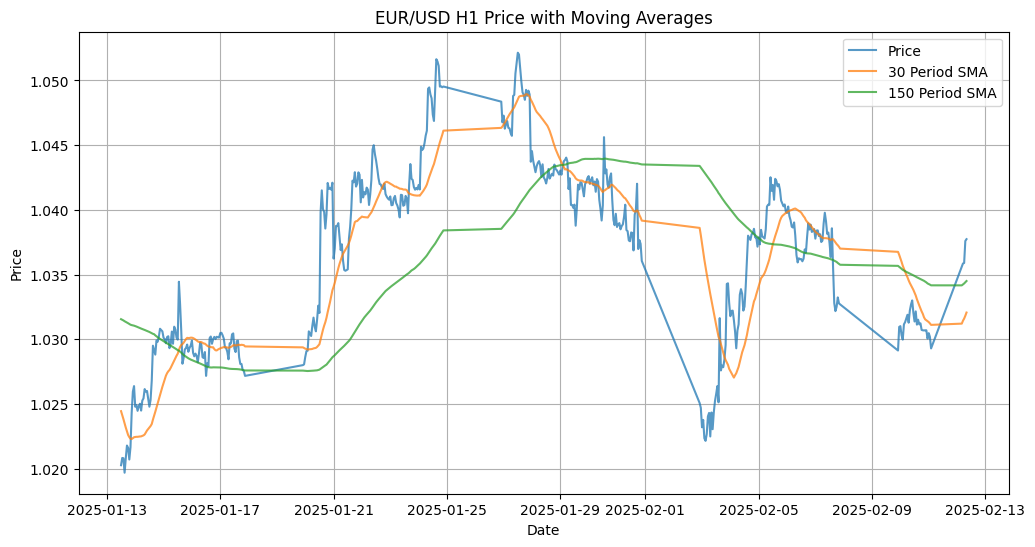

In [5]:
# Calculate moving averages
df_EURUSD_H1["SMA_30"] = calculate_sma(df_EURUSD_H1["close"], [30])[
    "sma_30"
]  # Pass period as a list
df_EURUSD_H1["SMA_150"] = calculate_sma(df_EURUSD_H1["close"], [150])[
    "sma_150"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_H1.index[-500:], df_EURUSD_H1["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD H1 Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

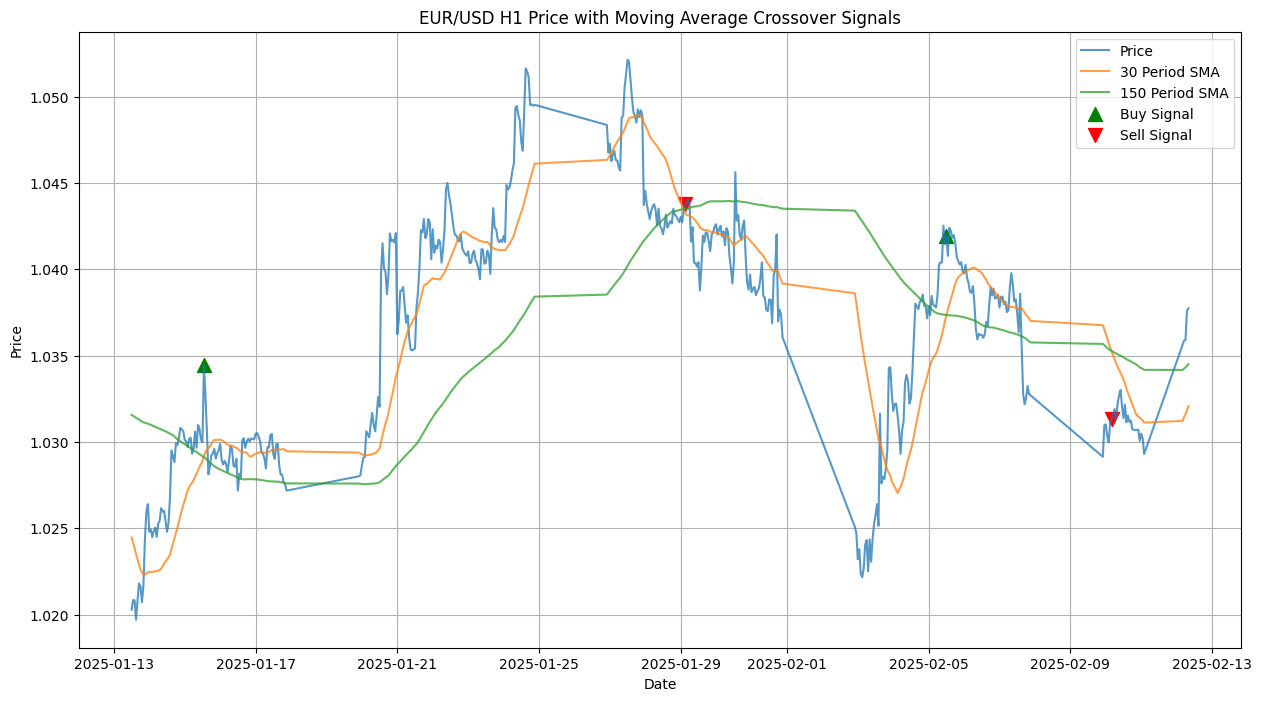


Crossover Signals:
                       close  signal
time                                
2015-02-24 00:00:00  1.13375      -1
2015-02-26 10:00:00  1.13601       1
2015-02-26 13:00:00  1.12588      -1
2015-03-18 10:00:00  1.06238       1
2015-03-29 21:00:00  1.08897      -1
2015-04-03 04:00:00  1.08793       1
2015-04-08 08:00:00  1.08592      -1
2015-04-16 12:00:00  1.07412       1
2015-04-23 13:00:00  1.07522      -1
2015-04-23 18:00:00  1.08264       1
2015-05-11 01:00:00  1.11592      -1
2015-05-13 07:00:00  1.12508       1
2015-05-19 13:00:00  1.11540      -1
2015-05-31 23:00:00  1.09572       1
2015-06-02 03:00:00  1.09276      -1
2015-06-02 09:00:00  1.09822       1
2015-06-12 10:00:00  1.11839      -1
2015-06-17 21:00:00  1.13409       1
2015-06-23 12:00:00  1.11690      -1
2015-07-09 11:00:00  1.10593       1
2015-07-14 05:00:00  1.09966      -1
2015-07-22 10:00:00  1.09246       1
2015-07-30 11:00:00  1.09554      -1
2015-08-10 02:00:00  1.09624       1
2015-08-18 07:00:0

In [6]:
import numpy as np

def identify_ma_crossovers(df, fast_col="SMA_30", slow_col="SMA_150"):
    """
    Identify MA crossover signals
    Returns DataFrame with signals: 1 for buy, -1 for sell, 0 for no signal
    """
    # Initialize signal column
    df["signal"] = 0

    # Create crossover signals
    df["signal"] = np.where(
        (df[fast_col] > df[slow_col])
        & (df[fast_col].shift(1) <= df[slow_col].shift(1)),
        1,  # Buy signal
        np.where(
            (df[fast_col] < df[slow_col])
            & (df[fast_col].shift(1) >= df[slow_col].shift(1)),
            -1,  # Sell signal
            0,  # No signal
        ),
    )

    return df


# Apply the crossover strategy
df_EURUSD_H1 = identify_ma_crossovers(df_EURUSD_H1)

# Plot with signals
plt.figure(figsize=(15, 8))

# Plot price and MAs
plt.plot(
    df_EURUSD_H1.index[-500:], df_EURUSD_H1["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H1.index[-500:],
    df_EURUSD_H1["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

# Plot buy signals
plt.scatter(
    df_EURUSD_H1.index[-500:][df_EURUSD_H1["signal"][-500:] == 1],
    df_EURUSD_H1["close"][-500:][df_EURUSD_H1["signal"][-500:] == 1],
    marker="^",
    color="green",
    s=100,
    label="Buy Signal",
)

# Plot sell signals
plt.scatter(
    df_EURUSD_H1.index[-500:][df_EURUSD_H1["signal"][-500:] == -1],
    df_EURUSD_H1["close"][-500:][df_EURUSD_H1["signal"][-500:] == -1],
    marker="v",
    color="red",
    s=100,
    label="Sell Signal",
)

plt.title("EUR/USD H1 Price with Moving Average Crossover Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print recent signals
signals = df_EURUSD_H1[df_EURUSD_H1["signal"] != 0]
print("\nCrossover Signals:")
print(signals[["close", "signal"]].to_string())

In [7]:
def backtest_signals(df):
    """
    Backtest trades based on MA crossover signals.

    The strategy:
    - Enter a trade at the close on a signal candle (1 for buy, -1 for sell).
    - Exit when the signal reverses (from buy to sell or sell to buy).
    - If a trade is open at the end of the data, exit at the final candle's close.

    Returns a list of trades with entry/exit times & prices, and the pip gain.
    """
    trades = []
    open_trade = None

    # Ensure the DataFrame is sorted by time
    df = df.sort_index()

    for time, row in df.iterrows():
        signal = row["signal"]
        price = row["close"]

        # If there is a signal (non-zero)
        if signal != 0:
            # If no trade is open, open one
            if open_trade is None:
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }
            # If a trade is already open and the new signal is different (a reversal)
            elif signal != open_trade["signal"]:
                exit_price = price
                exit_time = time
                if open_trade["signal"] == 1:  # Buy trade
                    pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                else:  # Sell trade
                    pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                trade = {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": exit_time,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                }
                trades.append(trade)
                # Open a new trade with the current signal
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }

    # If a trade is still open at the end, close it at the last available candle
    if open_trade is not None:
        last_time = df.index[-1]
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            pip_gain = (open_trade["entry_price"] - last_price) * 10000
        trade = {
            "entry_time": open_trade["entry_time"],
            "exit_time": last_time,
            "entry_price": open_trade["entry_price"],
            "exit_price": last_price,
            "signal": open_trade["signal"],
            "pip_gain": pip_gain,
        }
        trades.append(trade)

    return trades


# Run the backtest on the DataFrame with crossover signals
trade_results = backtest_signals(df_EURUSD_H1)

# Convert results to a DataFrame for analysis
trades_df = pd.DataFrame(trade_results)
print("\nBacktest Trade Results:")
print(trades_df)

# Optionally, summarize overall performance
if not trades_df.empty:
    total_pips = trades_df["pip_gain"].sum()
    num_trades = len(trades_df)
    avg_pips = trades_df["pip_gain"].mean()
    print(f"\nTotal trades: {num_trades}")
    print(f"Total pip gain: {total_pips:.1f} pips")
    print(f"Average pip gain per trade: {avg_pips:.1f} pips")


Backtest Trade Results:
             entry_time           exit_time  entry_price  exit_price  signal  \
0   2015-02-24 00:00:00 2015-02-26 10:00:00      1.13375     1.13601    -1.0   
1   2015-02-26 10:00:00 2015-02-26 13:00:00      1.13601     1.12588     1.0   
2   2015-02-26 13:00:00 2015-03-18 10:00:00      1.12588     1.06238    -1.0   
3   2015-03-18 10:00:00 2015-03-29 21:00:00      1.06238     1.08897     1.0   
4   2015-03-29 21:00:00 2015-04-03 04:00:00      1.08897     1.08793    -1.0   
..                  ...                 ...          ...         ...     ...   
534 2025-01-08 15:00:00 2025-01-15 13:00:00      1.03016     1.03445    -1.0   
535 2025-01-15 13:00:00 2025-01-29 03:00:00      1.03445     1.04376     1.0   
536 2025-01-29 03:00:00 2025-02-05 12:00:00      1.04376     1.04192    -1.0   
537 2025-02-05 12:00:00 2025-02-10 04:00:00      1.04192     1.03133     1.0   
538 2025-02-10 04:00:00 2025-02-12 08:00:00      1.03133     1.03774    -1.0   

     pip_gain 

In [8]:
def performance_metrics(trades_df):
    trades_df["winning"] = trades_df["pip_gain"] > 0
    win_rate = trades_df["winning"].mean()  # fraction of winning trades
    avg_win = (
        trades_df.loc[trades_df["pip_gain"] > 0, "pip_gain"].mean()
        if trades_df.loc[trades_df["pip_gain"] > 0].shape[0]
        else 0
    )
    avg_loss = (
        trades_df.loc[trades_df["pip_gain"] <= 0, "pip_gain"].mean()
        if trades_df.loc[trades_df["pip_gain"] <= 0].shape[0]
        else 0
    )

    # Build an equity curve from pip gains
    equity_curve = trades_df["pip_gain"].cumsum()
    running_max = equity_curve.cummax()
    drawdown = equity_curve - running_max
    max_drawdown = drawdown.min()

    return win_rate, avg_win, avg_loss, max_drawdown, equity_curve


# Assuming trades_df is already produced by your backtest:
win_rate, avg_win, avg_loss, max_drawdown, equity_curve = performance_metrics(trades_df)
print(f"Win rate: {win_rate*100:.1f}%")
print(f"Average win: {avg_win:.1f} pips")
print(f"Average loss: {avg_loss:.1f} pips")
print(f"Maximum drawdown: {max_drawdown:.1f} pips")

Win rate: 35.6%
Average win: 103.4 pips
Average loss: -53.2 pips
Maximum drawdown: -1571.9 pips
